In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
#spacy for lemmatization
import spacy

In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Remove deprecationWarning that I can't fix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# NLTK for removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'davao','ordinance', 'thereof', 'section'])

In [7]:
# Import CSV Ordinance Dataset
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


In [8]:
# List all ordinance titles
# Convert to list
data = list(df.OT) 
print(data[:1])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


In [9]:
# Remove qoutes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]

# Remove words ending with ING like amending, regulating
# Implemtation to be improved / Seems to improve topics
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]


pprint(data[:5])

['“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES '
 'ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.',
 '“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) '
 'ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE '
 'UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, '
 'REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE '
 'PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”.',
 '“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT TAGUMENYOS, ITS '
 'MANAGEMENT, PROCEDURES AND GUIDELINES AND FUNDS THEREFOR”.',
 'AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE '
 'NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT '
 'BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS '
 '(P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF '
 'SERVICE VEHICLES, ACQUISITION O

In [10]:
#preprocess using gensim simple_preprocess and tokenize into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:5])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang'],
 ['an',
  'ordinance',
  'the',
  'members',
  'of',
  'the',
  'city',
  'tricycle',
  'and',
  'regulatory',
  'board',
  'ctfrb',
  'its',
  'functions',
  'and',
  'procedures',
  'and',
  'motorized',
  'tricycle',
  'for',
  'hire',
  'mth',
  'tricycle',
  'utility',
  'vehicle',
  'tuv',
  'and',
  'tricycle',
  'utility',
  'for',
  'hire',
  'tuh',
  'guidelines',
  'regulations',
  'and',
  'operations',
  'the',
  'collection',
  'of',
  'fees',
  'charges',
  'administrative',
  'provisions',
  'and',
  'penalties',
  'for',
  'violation',
  'thereof'],
 ['an',
  'ordinance',
  'funeral',
  'and',
  'burial',
  'assistance',
  'for',
  'indigent',
  'tagumenyos',
  'its',
  'management',
  'procedures',
  'and',
  'guidelines',
  'and',
  'funds',
  'theref

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[1]]])

['an',
 'ordinance',
 'the',
 'members',
 'of',
 'the',
 'city',
 'tricycle',
 'and',
 'regulatory_board_ctfrb',
 'its',
 'functions',
 'and',
 'procedures',
 'and',
 'motorized_tricycle',
 'for',
 'hire_mth',
 'tricycle',
 'utility',
 'vehicle',
 'tuv',
 'and',
 'tricycle',
 'utility',
 'for',
 'hire',
 'tuh',
 'guidelines',
 'regulations',
 'and',
 'operations',
 'the',
 'collection',
 'of',
 'fees',
 'charges',
 'administrative',
 'provisions',
 'and',
 'penalties',
 'for',
 'violation',
 'thereof']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Code snippets from Selva Prabhakaran | Topic Modeling with Gensim (Python)
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
# Remove Stop Words and Form Bigrams
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Lematize keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(data_lemmatized[:1])

[['practice',
  'traditional',
  'home',
  'birth',
  'delivery',
  'delivery',
  'attend',
  'traditional',
  'birth',
  'attendant',
  'mananabang']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 2)]]


In [15]:
id2word[0]

'attend'

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attend', 1),
  ('attendant', 1),
  ('birth', 2),
  ('delivery', 2),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.036*"position" + 0.030*"fund" + 0.026*"purpose" + 0.026*"government" + 0.022*"necessary" + 0.020*"new" + 0.019*"legislative" + 0.018*"tax" + 0.017*"compensation" + 0.016*"officer"'), (1, '0.072*"public" + 0.043*"market" + 0.028*"use" + 0.026*"regulation" + 0.023*"service" + 0.022*"road" + 0.020*"penalty" + 0.018*"business" + 0.016*"amount" + 0.016*"year"'), (2, '0.052*"fund" + 0.031*"guideline" + 0.030*"duty" + 0.020*"traffic" + 0.020*"purpose" + 0.019*"function" + 0.018*"territorial_jurisdiction" + 0.017*"private" + 0.016*"program" + 0.016*"policy"'), (3, '0.098*"municipal" + 0.027*"area" + 0.026*"violation" + 0.024*"penalty" + 0.019*"street" + 0.018*"purpose" + 0.017*"provide" + 0.012*"portion" + 0.010*"establishment" + 0.010*"cover"'), (4, '0.065*"municipality" + 0.060*"violation" + 0.055*"penalty" + 0.037*"fee" + 0.028*"vehicle" + 0.026*"operation" + 0.015*"utility" + 0.012*"rate" + 0.012*"passenger" + 0.011*"permit"')]


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.667816605392877

Coherence Score:  0.4419491796518886


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.215755 -0.061590       1        1  22.588448
3      0.128550 -0.070858       2        1  21.637988
1     -0.009040  0.282956       3        1  19.217542
0     -0.176893 -0.060406       4        1  18.394626
2     -0.158372 -0.090102       5        1  18.161396, topic_info=              Term        Freq       Total Category  logprob  loglift
261      municipal  105.000000  105.000000  Default  30.0000  30.0000
143         public   69.000000   69.000000  Default  29.0000  29.0000
448   municipality   72.000000   72.000000  Default  28.0000  28.0000
22       violation   94.000000   94.000000  Default  27.0000  27.0000
23            fund   73.000000   73.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
122  establishment   11.341735   27.426994   Topic5  -4.3697   0.8228
135         revise    7.847582   14.475583   Topic5  -4.7380   1.0936
105           code    7.504263   14.696871   Topic5  -4.7828   1.0337
429         vendor    6.471595   11.377125   Topic5  -4.9308   1.1417
34          school    6.662531   16.587131   Topic5  -4.9017   0.7937

[221 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
79        3  0.911153            act
353       4  0.954941     additional
863       4  0.883658  administrator
487       2  0.931053   agricultural
202       4  0.869916          amend
...     ...       ...            ...
22        2  0.286196      violation
76        5  0.879637         worker
53        3  0.839466           year
53        5  0.111929           year
78        2  0.906702           zone

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [21]:
# Build Mallet LDA Model
mallet_path = '/Users/root1/Documents/lda/mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word)

In [32]:
# Show Topics
# Only few topics make sense for me
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('penalty', 0.3225806451612903),
   ('violation', 0.2785923753665689),
   ('charge', 0.0469208211143695),
   ('clock', 0.02932551319648094),
   ('close', 0.020527859237536656),
   ('temporary', 0.017595307917888565),
   ('payment', 0.01466275659824047),
   ('regulate', 0.011730205278592375),
   ('supervise', 0.008797653958944282),
   ('toll', 0.008797653958944282)]),
 (8,
  [('purpose', 0.22916666666666666),
   ('street', 0.05952380952380952),
   ('portion', 0.05357142857142857),
   ('composition', 0.041666666666666664),
   ('traffic', 0.041666666666666664),
   ('fund', 0.03273809523809524),
   ('condition', 0.023809523809523808),
   ('term', 0.023809523809523808),
   ('child', 0.017857142857142856),
   ('corner', 0.017857142857142856)]),
 (3,
  [('fund', 0.11403508771929824),
   ('position', 0.1111111111111111),
   ('duty', 0.08771929824561403),
   ('legislative', 0.06725146198830409),
   ('local', 0.06432748538011696),
   ('compensation', 0.049707602339181284),
   ('officer',

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

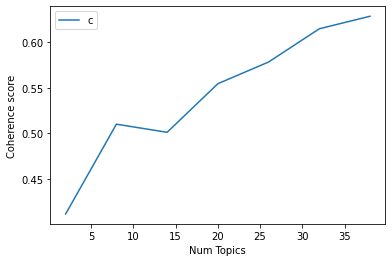

In [25]:
# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores with increasing number of topics

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4117
Num Topics = 8  has Coherence Value of 0.5101
Num Topics = 14  has Coherence Value of 0.5012
Num Topics = 20  has Coherence Value of 0.5544
Num Topics = 26  has Coherence Value of 0.5782
Num Topics = 32  has Coherence Value of 0.6146
Num Topics = 38  has Coherence Value of 0.6284


In [36]:
# Select the model and print the topics
optimal_model = model_list[2] # when number of topics is 8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.288*"violation" + 0.246*"penalty" + 0.030*"place" + 0.021*"installation" '
  '+ 0.015*"poblacion" + 0.012*"date" + 0.012*"limit" + 0.012*"regulate" + '
  '0.012*"lapu" + 0.012*"motor"'),
 (1,
  '0.197*"public" + 0.116*"market" + 0.087*"vehicle" + 0.084*"penalty" + '
  '0.041*"private" + 0.041*"utility" + 0.035*"passenger" + 0.017*"stall" + '
  '0.017*"movie" + 0.014*"moviehouse"'),
 (2,
  '0.157*"fee" + 0.063*"service" + 0.051*"operation" + 0.048*"charge" + '
  '0.048*"provision" + 0.042*"permit" + 0.042*"procedure" + 0.024*"tricycle" + '
  '0.021*"jeepney" + 0.021*"truck"'),
 (3,
  '0.153*"government" + 0.085*"operation" + 0.072*"rate" + 0.062*"function" + '
  '0.052*"development" + 0.046*"sale" + 0.036*"composition" + 0.026*"document" '
  '+ 0.026*"term" + 0.023*"salary"'),
 (4,
  '0.107*"establishment" + 0.060*"mayor" + 0.057*"person" + 0.054*"business" + '
  '0.039*"commercial" + 0.033*"house" + 0.030*"system" + 0.030*"residential" + '
  '0.027*"material" + 0.027*"structu

In [28]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.0661,"purpose, commercial, structure, cable, clearan...",“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME...
1,1,6.0,0.1796,"guideline, operation, function, charge, proced...",“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE...
2,2,6.0,0.0572,"guideline, operation, function, charge, proced...",“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FO...
3,3,12.0,0.0830,"municipality, territorial_jurisdiction, owner,...","AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 A..."
4,4,18.0,0.0464,"purpose, commercial, structure, cable, clearan...","“AN ORDINANCE THE CITY HISTORICAL, CULTURAL AN..."
5,5,7.0,0.0498,"fund, duty, expense, comprehensive, employee, ...",“AN ORDINANCE THE HUGPONG SERBISYO PARA SA TAG...
6,6,23.0,0.0562,"area, situate, continue_reade, cover, locate, ...",“AN ORDINANCE THE AREA IN FRONT OF THE HISTORI...
7,7,24.0,0.0562,"public, school, person, private, provide, movi...",AN ORDINANCE SECTION 2 OF CITY ORDINANCE NO. 2...
8,8,13.0,0.0627,"portion, construction, term, condition, barang...",AN ORDINANCE THE TEMPORARY CLOSURE OF PORTIONS...
9,9,1.0,0.1408,"road, street, traffic, continue_reading, place...",“AN ORDINANCE TEMPORARY CLOSURE FROM CORNER R...


In [37]:
# Convert malletmodel to to gensim lda model for pyLDAvis
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.121091  0.013452       1        1  7.107379
10     0.046045  0.041880       2        1  6.830498
0     -0.008386  0.184422       3        1  6.810108
3     -0.291675 -0.163627       4        1  6.772628
8     -0.202000  0.102510       5        1  6.706094
6      0.053200  0.053193       6        1  6.695667
14     0.097447 -0.068214       7        1  6.671229
7      0.145183 -0.201783       8        1  6.624560
4      0.075597 -0.020227       9        1  6.605830
1     -0.297742 -0.159278      10        1  6.578475
13     0.042735  0.138869      11        1  6.562204
9     -0.011394  0.174130      12        1  6.560655
5      0.190281 -0.209204      13        1  6.552701
12     0.059987 -0.045239      14        1  6.490826
11    -0.020369  0.159115      15        1  6.431145, topic_info=          Term        Freq       Total Category  logprob  loglift
16     penalty  109.000000  109.000000  Default  30.0000  30.0000
261  municipal  107.000000  107.000000  Default  29.0000  29.0000
22   violation   94.000000   94.000000  Default  28.0000  28.0000
74     purpose   79.000000   79.000000  Default  27.0000  27.0000
23        fund  106.000000  106.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
37   afternoon    2.235049    3.220007  Topic15  -4.9558   2.3789
767  clearance    3.352574    6.373152  Topic15  -4.5504   2.1017
739      limit    2.235049    4.189606  Topic15  -4.9558   2.1157
4         home    2.235049    5.435224  Topic15  -4.9558   1.8554
34      school    2.235049   24.979077  Topic15  -4.9558   0.3302

[807 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1068      8  0.914591       abbatoir
196      15  0.894835         access
500      10  1.028807       accident
284       3  0.652630  accreditation
284       8  0.326315  accreditation
...     ...       ...            ...
76       13  0.151387         worker
624       9  0.923319      workplace
53       14  0.984723           year
78        6  0.715672           zone
78       11  0.238557           zone

[870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 1, 4, 9, 7, 15, 8, 5, 2, 14, 10, 6, 13, 12])